In [1]:
%matplotlib inline


# Forward Simulation of Gradiometry Data on a Tree Mesh

Here we use the module *SimPEG.potential_fields.gravity* to predict gravity
gradiometry data for a synthetic density contrast model. The simulation is
carried out on a tree mesh. For this tutorial, we focus on the following:

    - How to define the survey when we want multiple field components
    - How to predict gravity gradiometry data for a density contrast model
    - How to construct tree meshes based on topography and survey geometry
    - The units of the density contrast model and resulting data


## Import Modules




In [2]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import gravity

# sphinx_gallery_thumbnail_number = 2

## Defining Topography

Surface topography is defined as an (N, 3) numpy array. We create it here but
the topography could also be loaded from a file.




In [3]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

## Defining the Survey

Here, we define survey that will be used for the forward simulation. Gravity
surveys are simple to create. The user only needs an (N, 3) array to define
the xyz locations of the observation locations, and a list of field components
which are to be measured.




In [4]:
# Define the observation locations as an (N, 3) numpy array or load them
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 5
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as strings within
# a list. Here we measure the x, y and z components of the gravity anomaly at
# each observation location.
components = ["gxz", "gyz", "gzz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Defining the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey
survey = gravity.survey.Survey(source_field)

## Defining an OcTree Mesh

Here, we create the OcTree mesh that will be used in the forward simulation.




In [5]:
dx = 5  # minimum cell width (base mesh cell width) in x
dy = 5  # minimum cell width (base mesh cell width) in y
dz = 5  # minimum cell width (base mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in z

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine based on surface topography
mesh = refine_tree_xyz(
    mesh, xyz_topo, octree_levels=[2, 2], method="surface", finalize=False
)

# Refine box based on region of interest
xp, yp, zp = np.meshgrid([-100.0, 100.0], [-100.0, 100.0], [-80.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]

mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2, 2], method="box", finalize=False)

mesh.finalize()

C:\Users\devin\AppData\Local\Temp\ipykernel_21688\2250962203.py:21: DeprecationWarning: The surface option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_surface` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(
C:\Users\devin\AppData\Local\Temp\ipykernel_21688\2250962203.py:29: DeprecationWarning: The box option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_bounding_box` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2, 2], method="box", finalize=False)


## Density Contrast Model and Mapping on OcTree Mesh

Here, we create the density contrast model that will be used to simulate gravity
gradiometry data and the mapping from the model to the mesh. The model
consists of a less dense block and a more dense sphere.




C:\Users\devin\AppData\Local\Temp\ipykernel_21688\2823219815.py:30: FutureWarning: getIndicesSphere has been deprecated, please use get_indices_sphere. It will be removed in version 0.19.0 of SimPEG.
  ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)


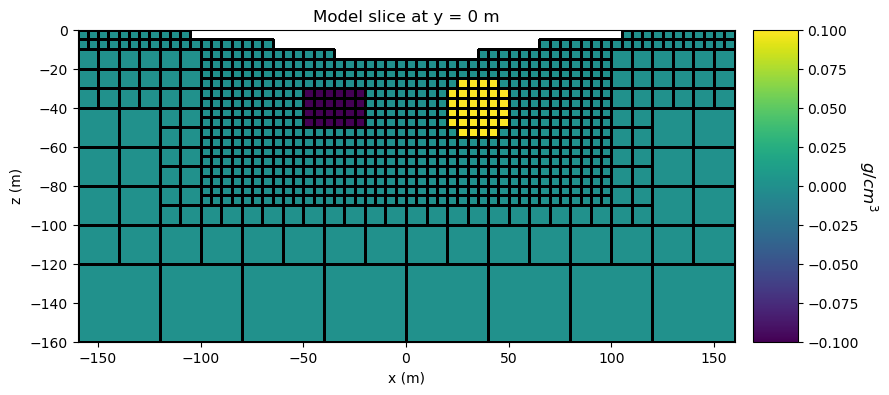

In [6]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.1
sphere_density = 0.1

# Find the indecies for the active mesh cells (e.g. cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model will be value of active cells

# Define model. Models in SimPEG are vector arrays.
model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -50.0)
    & (mesh.gridCC[ind_active, 0] < -20.0)
    & (mesh.gridCC[ind_active, 1] > -15.0)
    & (mesh.gridCC[ind_active, 1] < 15.0)
    & (mesh.gridCC[ind_active, 2] > -50.0)
    & (mesh.gridCC[ind_active, 2] < -30.0)
)
model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_density

# Plot Density Contrast Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

## Simulation: Gravity Gradiometry Data on an OcTree Mesh

Here we demonstrate how to predict gravity anomaly data using the integral
formulation.




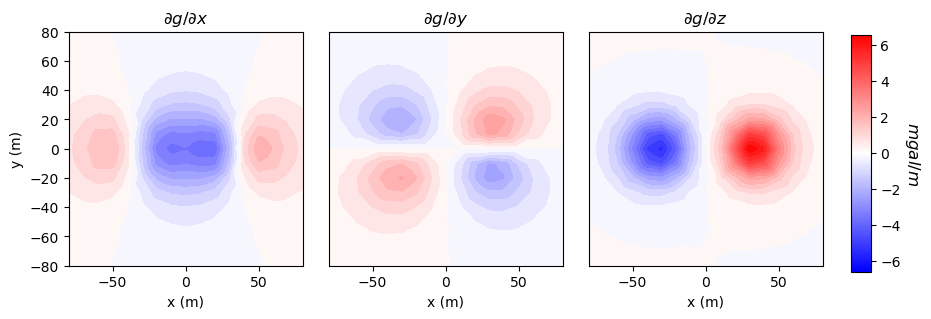

In [7]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
dpred = simulation.dpred(model)
n_data = len(dpred)

# Plot
fig = plt.figure(figsize=(10, 3))
n_locations = receiver_locations.shape[0]
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.15, 0.25, 0.78])
cplot1 = plot2Ddata(
    receiver_locations,
    dpred[0:n_data:3],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot1[0].set_clim((-v_max, v_max))
ax1.set_title(r"$\partial g /\partial x$")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.36, 0.15, 0.25, 0.78])
cplot2 = plot2Ddata(
    receiver_locations,
    dpred[1:n_data:3],
    ax=ax2,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot2[0].set_clim((-v_max, v_max))
ax2.set_title(r"$\partial g /\partial y$")
ax2.set_xlabel("x (m)")
ax2.set_yticks([])

ax3 = fig.add_axes([0.62, 0.15, 0.25, 0.78])
cplot3 = plot2Ddata(
    receiver_locations,
    dpred[2:n_data:3],
    ax=ax3,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot3[0].set_clim((-v_max, v_max))
ax3.set_title(r"$\partial g /\partial z$")
ax3.set_xlabel("x (m)")
ax3.set_yticks([])

ax4 = fig.add_axes([0.89, 0.13, 0.02, 0.79])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax4, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$mgal/m$", rotation=270, labelpad=15, size=12)

plt.show()